# Importing Libraries

In [96]:
# Standard Library
import os

# Data Science Libraries
import pandas as pd
import numpy as np

# Plotting Libraries
import matplotlib.pyplot as plt

# Machine Learning Libraries (Scikit-learn)
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Deep Learning Libraries (TensorFlow/Keras)
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import InputLayer, LSTM, Dense, Bidirectional
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

# Loading the Data into a Pandas DataFrame

In [97]:
# Define the path to the CSV file containing air quality data
csv_path = 'AirQualityIndex6years.csv'

# Read the CSV file into a DataFrame using pandas
df = pd.read_csv(csv_path)

# Display the first 5 rows of the DataFrame to check the data
df.head()

,Date,Overall AQI Value,Main Pollutant,Site Name (of Overall AQI),Site ID (of Overall AQI),Source (of Overall AQI),CO,Ozone,PM10,PM25,NO2
0,01/01/2018,86,PM2.5,Chico-East Avenue,06-007-0008,AQS,9,30,32,86,20
1,02/01/2018,73,PM2.5,"TRAFFIC, RURAL PAVED ROAD",06-007-4001,AQS,9,35,25,73,22
2,03/01/2018,41,Ozone,Paradise - Airport,06-007-0007,AQS,2,41,7,34,4
3,04/01/2018,52,PM2.5,"TRAFFIC, RURAL PAVED ROAD",06-007-4001,AQS,2,46,8,52,8
4,05/01/2018,51,PM2.5,Chico-East Avenue,06-007-0008,AQS,2,44,10,51,8


# Preprocessing

In [98]:
df.columns = (
    df.columns
      .str.replace('\ufeff', '', regex=False)  # Xóa BOM nếu có
      .str.strip()
)

# Parse Date (dd/mm/yyyy) + set index + sort
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
df = df.set_index('Date').sort_index()

In [99]:
df.drop(columns=[
    'Site Name (of Overall AQI)',
    'Main Pollutant',
    'Site ID (of Overall AQI)',
    'Source (of Overall AQI)'
], inplace=True, errors='ignore')

In [100]:
# Thay '-' thành NaN và fill forward
df.replace('-', np.nan, inplace=True)

# Convert các cột chỉ số ô nhiễm sang numeric
for col in ['CO', 'Ozone', 'PM10', 'PM25', 'NO2', 'Overall AQI Value']:
    df[col] = pd.to_numeric(df[col], errors='coerce')


df.ffill(inplace=True)

,Overall AQI Value,CO,Ozone,PM10,PM25,NO2
Date,,,,,,
2018-01-01,86,9.0,30.0,32.0,86,20.0
2018-01-02,73,9.0,35.0,25.0,73,22.0
2018-01-03,41,2.0,41.0,7.0,34,4.0
2018-01-04,52,2.0,46.0,8.0,52,8.0
2018-01-05,51,2.0,44.0,10.0,51,8.0


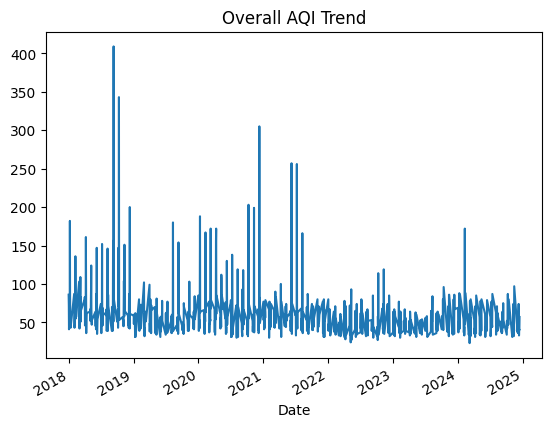

In [101]:
# Tạo DataFrame temp với 5 features + target
feature_cols = ['CO', 'Ozone', 'PM10', 'PM25', 'NO2']
target_col   = 'Overall AQI Value'
temp = df[feature_cols + [target_col]].copy()

# Plot xu hướng AQI
temp[target_col].plot(title="Overall AQI Trend")

df.head()

In [102]:
def df_to_X_y(df, feature_cols, target_col, window_size=64):
    X_mat = df[feature_cols].to_numpy(dtype=np.float32)   # (T, n_features)
    y_vec = df[target_col].to_numpy(dtype=np.float32)     # (T,)

    X, y, indices = [], [], []
    for t in range(window_size, len(df)):
        X.append(X_mat[t-window_size:t, :])   # (window, n_features)
        y.append(y_vec[t])                    # scalar
        indices.append(df.index[t])
    return np.stack(X), np.array(y), np.array(indices)

# --- dùng với 5 features của bạn ---
feature_cols = ["CO", "Ozone", "PM10", "PM25", "NO2"]
target_col   = "Overall AQI Value"
WINDOW_SIZE  = 64

X, y, indices = df_to_X_y(temp, feature_cols, target_col, WINDOW_SIZE)
print(X.shape, y.shape)  # -> (N, 64, 5)  (N,)



(2493, 64, 5) (2493,)


## Split to Train, Validation, and Test

In [103]:
from sklearn.model_selection import train_test_split


indices = np.arange(len(X))  

X_train_val, X_test, y_train_val, y_test, indices_train_val, indices_test = train_test_split(
    X, y, indices, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val, indices_train, indices_val = train_test_split(
    X_train_val, y_train_val, indices_train_val, test_size=0.25, random_state=42
)



In [104]:
scaler = MinMaxScaler()
n_timesteps, n_features = X_train.shape[1], X_train.shape[2]
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, n_features)).reshape(-1, n_timesteps, n_features)
X_val_scaled   = scaler.transform(X_val.reshape(-1, n_features)).reshape(-1, n_timesteps, n_features)
X_test_scaled  = scaler.transform(X_test.reshape(-1, n_features)).reshape(-1, n_timesteps, n_features)

In [105]:
# X_train, y_train: Training set (60%)
# X_val, y_val: Validation set (20%)
# X_test, y_test: Test set (20%)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1495, 64, 5)
y_train shape: (1495,)
X_val shape: (499, 64, 5)
y_val shape: (499,)
X_test shape: (499, 64, 5)
y_test shape: (499,)


# Training the Model

In [106]:
model = Sequential()

# Input layer
model.add(InputLayer(input_shape=(WINDOW_SIZE, len(feature_cols))))

# Thêm nhiều BiLSTM layers với dropout
model.add(Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
model.add(Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
model.add(Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2)))

# Thêm nhiều Dense layers với BatchNormalization và Dropout
from keras.layers import BatchNormalization, Dropout

model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(BatchNormalization())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))

# Output layer
model.add(Dense(1, activation='linear'))

# Summary
model.summary()

d:\Python 3.12\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_9 (Bidirectional) │ (None, 64, 256)        │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 64, 128)        │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 350,209 (1.34 MB)

 Trainable params: 349,889 (1.33 MB)

 Non-trainable params: 320 (1.25 KB)

In [107]:

cp = ModelCheckpoint('model1.keras', save_best_only=True, monitor='val_loss', mode='min')

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=10, 
    min_lr=1e-7,
    verbose=1
)

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

# Compile model với learning rate thấp hơn
model.compile(
    loss=MeanSquaredError(), 
    optimizer=Adam(learning_rate=0.0005),  # Giảm learning rate
    metrics=[RootMeanSquaredError()]
)

In [ ]:
# Train the model using the training data (X_train, y_train)
history = model.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val), 
    epochs=150,  # Tăng số epochs
    batch_size=32,  # Điều chỉnh batch size
    callbacks=[cp, lr_scheduler, early_stopping],
    verbose=1
)

# Plot training history

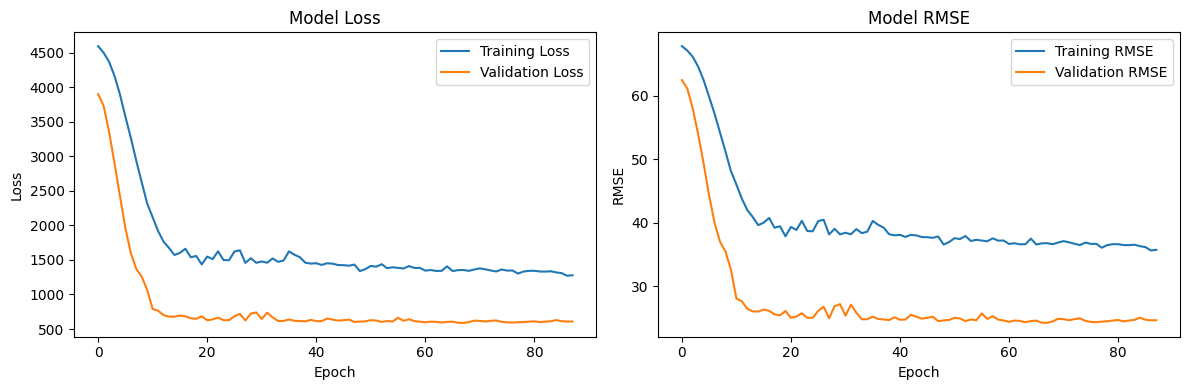

In [109]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.title('Model RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluating the Model

In [110]:
# Load the pre-trained model from the specified file path
model = tf.keras.models.load_model('model1.keras')

In [ ]:
y_pred = model.predict(X_test, batch_size=32).flatten()

# Create DataFrame for results
start_date = pd.to_datetime(temp.index.min())
max_index = indices_test.max()
date_range = pd.date_range(start=start_date, periods=len(temp))

# Use the indices to select corresponding dates from the date range
date_index = [temp.index[i] for i in indices_test]

# Create results DataFrame
results_df = pd.DataFrame({
    'Date': date_index,
    'y_test': y_test,
    'y_pred': y_pred
})

results_df.set_index('Date', inplace=True)
results_df.sort_index(ascending=True, inplace=True)

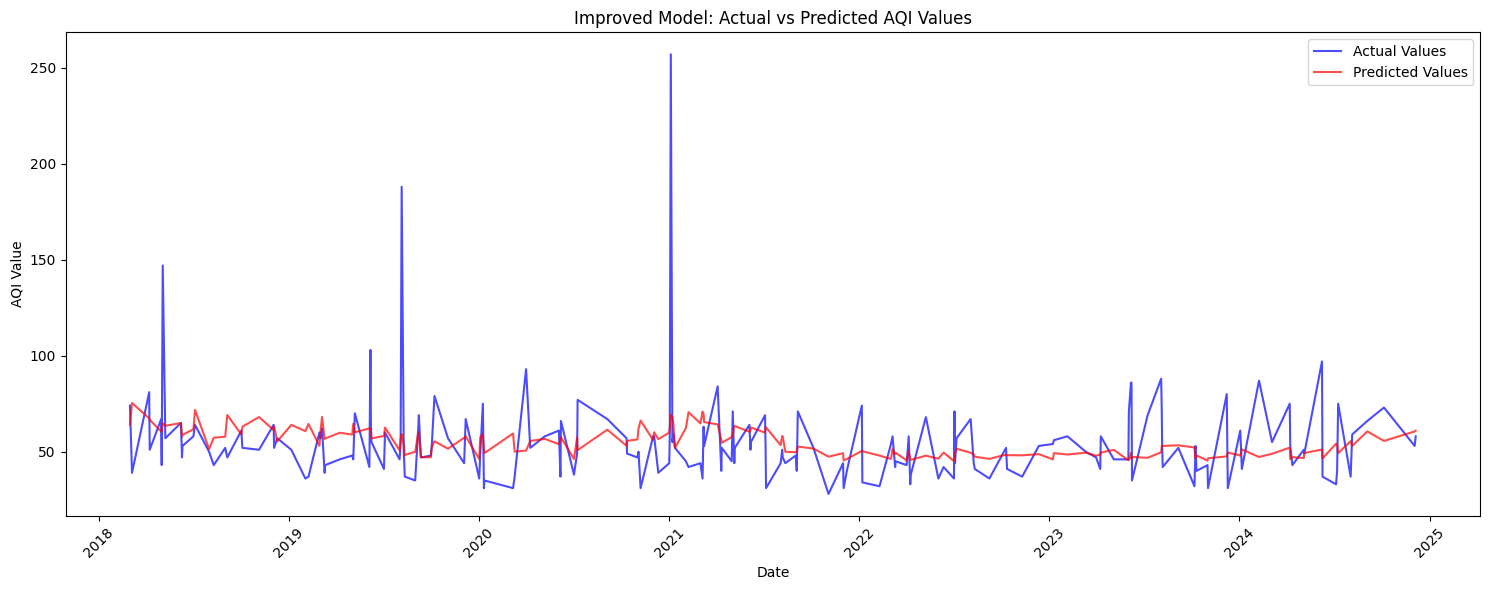

In [112]:
plt.figure(figsize=(15, 6))
plt.plot(results_df.index, results_df['y_test'], label='Actual Values', color='blue', alpha=0.7)
plt.plot(results_df.index, results_df['y_pred'], label='Predicted Values', color='red', alpha=0.7)
plt.title('Improved Model: Actual vs Predicted AQI Values')
plt.xlabel('Date')
plt.ylabel('AQI Value')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [113]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("=== MODEL EVALUATION ===")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

=== MODEL EVALUATION ===
Mean Absolute Error (MAE): 16.8862
Mean Squared Error (MSE): 823.9674
Root Mean Squared Error (RMSE): 28.7048
R-squared (R²): 0.0823


In [114]:
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Percentage Error (MAPE): 27.43%


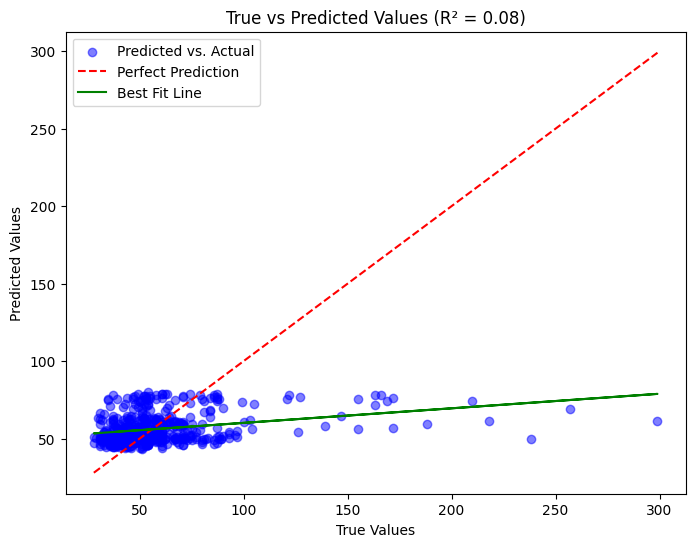

In [115]:
# Calculate R-squared
r2 = r2_score(y_test, y_pred)

# Fit a best-fit line
model = LinearRegression()
y_test_reshaped = np.array(y_test).reshape(-1, 1)  # Reshape for fitting
model.fit(y_test_reshaped, y_pred)
y_best_fit = model.predict(y_test_reshaped)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label="Predicted vs. Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label="Perfect Prediction")
plt.plot(y_test, y_best_fit, color='green', linestyle='-', label="Best Fit Line")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title(f"True vs Predicted Values (R² = {r2:.2f})")
plt.legend()
plt.show()